In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data= pd.read_csv('nyc_taxi_trip_duration.csv')
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


### Data Variables

- __id__ - a unique identifier for each trip
- __vendor_id__ - a code indicating the provider associated with the trip record
- __pickup_datetime__ - date and time when the meter was engaged
- __dropoff_datetime__ - date and time when the meter was disengaged
- __passenger_count__ - the number of passengers in the vehicle (driver entered value)
- __pickup_longitude__ - the longitude where the meter was engaged
- __pickup_latitude__ - the latitude where the meter was engaged
- __dropoff_longitude__ - the longitude where the meter was disengaged
- __dropoff_latitude__ - the latitude where the meter was disengaged
- __store_and_fwd_flag__ - This flag indicates whether the trip record was held in vehicle memory before sending to the - vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- __trip_duration__ - (target) duration of the trip in seconds

### Checking shape of the dataset

In [3]:
data.shape

(729322, 11)

### Missing values

In [4]:
data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values in the given dataset.

We can do the same column transformation and feature engineering steps we did in EDA.

### Data type conversion and feature engineering

We will do the following steps

- Convert data types as done in EDA
- Split the time stamp to create new features.
- Create distance and speed variable. The latter is simply being used for cleaning of data and will be removed later
- Perform the same steps of outlier removal as in EDA
- Create clusters of pick-up and drop-off
- Remove unwanted variables.

In [5]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

- Customer id is a randomly assigned unique identifier for a trip. So it can remain as an object and we will remove it.
- Vendor_id represents an id of the provider. This should be a category.
- Store_and_fwd_flag is object data type. But since we have only two possible values, it can be treated as a category.
- We will also only extract month, week and hour of pickup.

In [6]:
data['vendor_id']= data['vendor_id'].astype('category')
data['store_and_fwd_flag']= data['store_and_fwd_flag'].astype('category')

pickup_date= pd.DatetimeIndex(data['pickup_datetime'])

#Month of year of pick up
data['month_pickup']= pickup_date.month

#Week day of pick up
data['weekday_pickup']= pickup_date.weekday

#Hour of pick up
data['hour_pickup']= pickup_date.hour

#### Distance estimation using geopy

In [7]:
import geopy.distance
def distance_miles(row):
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geopy.distance.geodesic(coords_1, coords_2).miles

data['pickup_dropoff_distance'] = data.apply(distance_miles, axis=1)

#### Speed estimation

We may not use this feature in prediction. However, it can be a good variable for removing bad data.

In [8]:
def avg_speed(row):
    time_in_hours = row['trip_duration']/3600
    avg_speed= row['pickup_dropoff_distance']/time_in_hours
    return avg_speed

data['avg_speed'] = data.apply(avg_speed, axis=1)

In [9]:
data.dtypes

id                           object
vendor_id                  category
pickup_datetime              object
dropoff_datetime             object
passenger_count               int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
store_and_fwd_flag         category
trip_duration                 int64
month_pickup                  int64
weekday_pickup                int64
hour_pickup                   int64
pickup_dropoff_distance     float64
avg_speed                   float64
dtype: object

In [10]:
clean_data= data.copy()
#speed>120
clean_data= clean_data.drop(clean_data[data['avg_speed']>120].index)
#pickup and drop-off same
clean_data= clean_data.drop(clean_data[(clean_data['pickup_latitude']==clean_data['dropoff_latitude'])& (clean_data['pickup_longitude']==clean_data['dropoff_longitude'])].index)
#distance less than 10 miles and trip duration >30000 seconds
clean_data= clean_data.drop(clean_data[(clean_data['pickup_dropoff_distance']<10)& (clean_data['trip_duration']>20000)].index)
#trips with trip duration<10 seconds
clean_data= clean_data.drop(clean_data[clean_data['trip_duration']<10].index)

# Latitudes and longitudes 3 standard deviations away from their means

clean_data = clean_data[(clean_data['pickup_latitude'] < (clean_data['pickup_latitude'].mean() + 3*clean_data['pickup_latitude'].std()))
                   & (clean_data['pickup_latitude'] > (clean_data['pickup_latitude'].mean() - 3*clean_data['pickup_latitude'].std()))]
clean_data = clean_data[(clean_data['pickup_longitude'] < (clean_data['pickup_longitude'].mean() + 3*clean_data['pickup_longitude'].std()))
                   & (clean_data['pickup_longitude'] > (clean_data['pickup_longitude'].mean() - 3*clean_data['pickup_longitude'].std()))]
clean_data = clean_data[(clean_data['dropoff_latitude'] < (clean_data['dropoff_latitude'].mean() + 3*clean_data['dropoff_latitude'].std()))
                   & (clean_data['dropoff_latitude'] > (clean_data['dropoff_latitude'].mean() - 3*clean_data['dropoff_latitude'].std()))]
clean_data = clean_data[(clean_data['dropoff_longitude'] < (clean_data['dropoff_longitude'].mean() + 3*clean_data['dropoff_longitude'].std()))
                   & (clean_data['dropoff_longitude'] > (clean_data['dropoff_longitude'].mean() - 3*clean_data['dropoff_longitude'].std()))]

len(clean_data), len(data)

(658389, 729322)

In [11]:
from sklearn.cluster import KMeans
clean_data_pickup= clean_data[['pickup_longitude', 'pickup_latitude']]
clean_data_dropoff= clean_data[['dropoff_longitude', 'dropoff_latitude']]

pickup_cluster= KMeans(n_clusters=4, init='k-means++',random_state=42)
clean_data['pickup_cluster']= pickup_cluster.fit_predict(clean_data_pickup)

dropoff_cluster= KMeans(n_clusters=4, init='k-means++',random_state=42)
clean_data['dropoff_cluster']= dropoff_cluster.fit_predict(clean_data_dropoff)

In [12]:
clean_data= clean_data.drop(columns=['avg_speed', 'id', 'pickup_datetime', 'dropoff_datetime'])

In [13]:
clean_data.dtypes

vendor_id                  category
passenger_count               int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
store_and_fwd_flag         category
trip_duration                 int64
month_pickup                  int64
weekday_pickup                int64
hour_pickup                   int64
pickup_dropoff_distance     float64
pickup_cluster                int32
dropoff_cluster               int32
dtype: object

## Data Pre-processing

Here we will do steps like feature scaling and one-hot encoding of categorical variables.

Before we dive into pre-processing there are some considerations and thoughts.

We have got variables like __month_pickup__, __weekday_pickup__, __hour_pickup__ which are time variables. If we want to perform a linear regression, there are some restrictions in how we encode these variables. If we retain a numeric encoding (which is how they are currently encoded), the model will work poorly if the relationship between these time variables and the target variable (trip duration) is __not monotonic__.

But a tree based algorithm will ignore the non-monotonic relationship between these variables and the target and similar values will be grouped together. 

Let us look at the relationship once again on the clean data

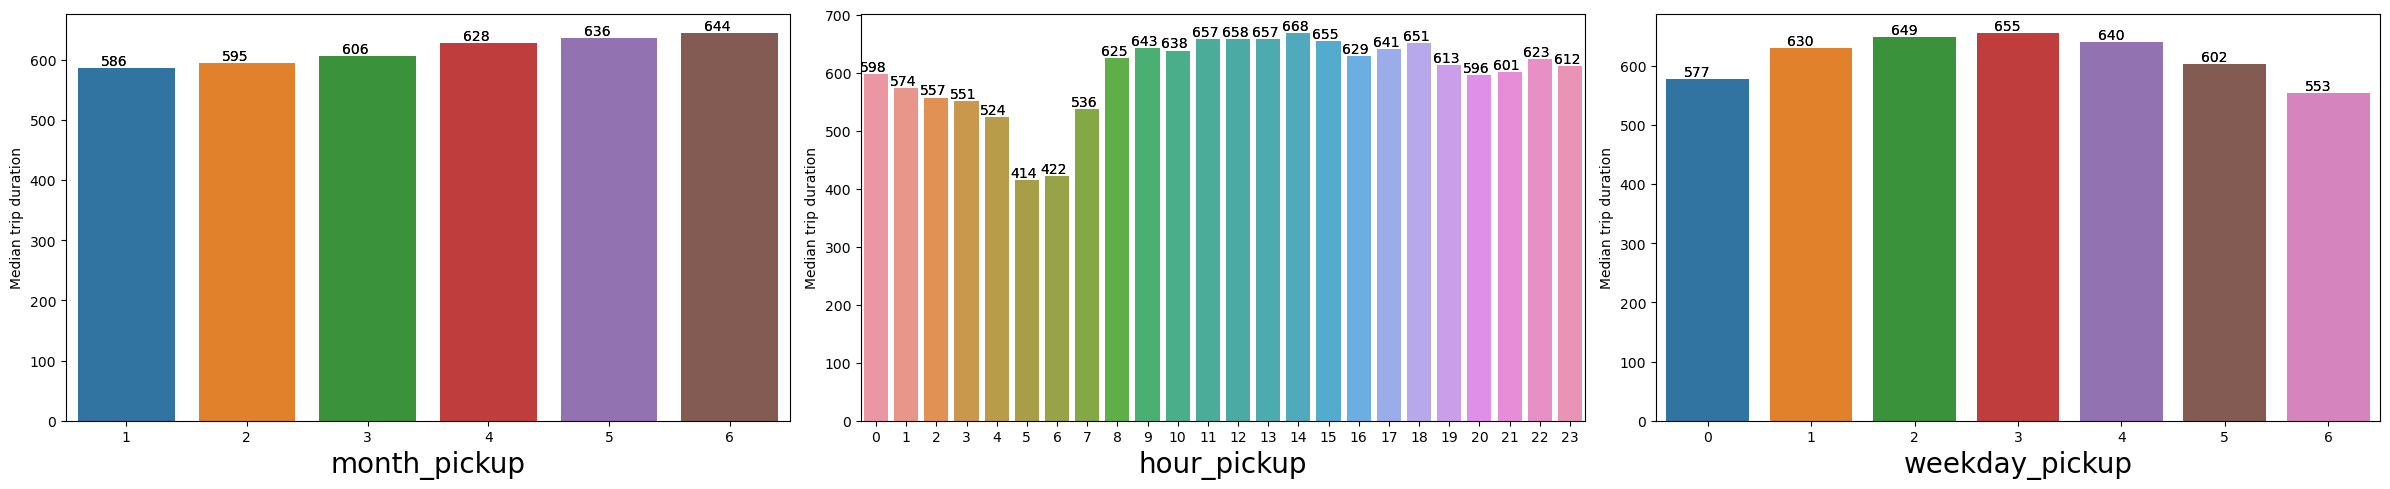

In [14]:
def medianplot(feature_list, figsize= (10,5)):
    
    size= len(feature_list)
    plt.figure(figsize = (8*size,5), dpi = 100)
    for j,i in enumerate(feature_list):
        x= clean_data.groupby(i)['trip_duration'].median().index
        y= clean_data.groupby(i)['trip_duration'].median().values
        plt.subplot(1,size,j+1)

        ax=sns.barplot(x=x, y=y)
        
        plt.xlabel('{}'.format(i), fontsize = 20)
        plt.ylabel('Median trip duration')
        for i in [0,1]:
            for p in ax.patches:
                ax.annotate('{:1.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                            ha='center', va='bottom',
                            color= 'black')
    plt.tight_layout()
    plt.show()
    
medianplot(["month_pickup",'hour_pickup','weekday_pickup'])

From our EDA and as shown above, there are varying trends across months, weekdays and hours. But they come in cycles. 

Trip durations were higher as we headed into weekends, was lowest on sundays and then picked up again. In months, we saw monotonic relationship between month and median trip duration. In hours, it was high from 9-6 PM and tapered off till morning. 

So even if we maintain the existing numerical encoding, a tree based algorithm can work relatively well.

In [15]:
clean_data= pd.get_dummies(clean_data,columns=['vendor_id','store_and_fwd_flag'])
clean_data.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'month_pickup', 'weekday_pickup', 'hour_pickup',
       'pickup_dropoff_distance', 'pickup_cluster', 'dropoff_cluster',
       'vendor_id_1', 'vendor_id_2', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y'],
      dtype='object')

I am unsure if we still need the coordinates since we already have pickup and drop-off clusters. We can try the model with them. If the features happen to have importance, we will retain them. If not, we can drop them and retrain and models.

Again, a tree based model needs no scaling of any kind as they are insensitive to variance in the data and make decisions based on thresholds. This is generally required by algorithms that work on gradient descent like linear regression, logistic regression, neural networks etc., or the ones that employ some sort of distance, like SVM or KNN that works on euclidean distance.



### Train- Test split 

In [16]:
y= clean_data.trip_duration
x= clean_data.drop(columns=['trip_duration'], axis=1)



from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3, random_state=42)

### Model Building and Evaluation

Since this is a regression problem, we will use __RMSE__ as the evaluation metric.

We will try the following models.

1. RandomForest
2. xgBoost

For evaluation, we will use a nested cross-validation approach. The __xtest__ and __ytest__ we created above will be kept separately and we will use it only in the end.

- **Step 1**: The __xtrain__ and __ytrain__ can be further split into __xtrain_inner__ and __ytrain__inner__ which will be the train set where we tune the hyper-parameters 
- **Step 2**: __xval_inner__ and __yval_inner__ will be used to evaluate the best model from each selected models.
- **Step 3**: The best seleted model will be trained on the entire train set __xtrain__ and __ytrain__
- **Step 4**: The model trained on step 3 will be tested on __xtest__ __ytest__



In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor


xtrain_inner, xval_inner, ytrain_inner, yval_inner = train_test_split(xtrain,ytrain,test_size=0.25, random_state=42)

xtrain_inner.shape, xval_inner.shape, ytrain_inner.shape, yval_inner.shape

((345654, 15), (115218, 15), (345654,), (115218,))

### RandomForest Regression

We will do a gridsearch on some hyper-parameters of Random Forest. This can take a lot of time.
Once we have the best model, we will evaluate that on the validation set.

In [38]:
param_vals = {'max_depth': [5,10,15,20], 'n_estimators': [50,100, 200]
              }

model= RandomForestRegressor()
rf= GridSearchCV(estimator=model, 
                 param_grid=param_vals,scoring='neg_mean_squared_error',
                refit= True,
                cv=5,
                n_jobs=-1)

In [39]:
rf.fit(xtrain_inner,ytrain_inner)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [46]:
best_rf= rf.best_estimator_
best_rf

RandomForestRegressor(max_depth=20, n_estimators=200)

From the given hyper-parameters, the regressor with max_depth= 20 and n_estimators=200 has the best cross validation accuracy from gridsearchCV.

We will not use this best estimator to make predictions on hold-out validation set.

In [48]:
pred= best_rf.predict(xval_inner)
np.sqrt(mean_squared_error(yval_inner,pred))

268.8997970327196

We have a RMSE of 268 seconds. This will be the score for random forest.

In [49]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(yval_inner,pred)

0.1456642524076152

### XGBRegressor

We will follow the same steps as in Randomforest: Do gridsearchCV and get best estimator and then benchmark the RMSE against what we got for the best random forest model.

In [19]:
from xgboost.sklearn import XGBRegressor
model = XGBRegressor()

In [20]:
param_vals = {
              'learning_rate': [0.01,.1, 0.2], #so called `eta` value
              'max_depth': [5, 8,10],
              'objective': ['reg:gamma'],
              'colsample_bytree': [0.5,0.7],
              'min_child_weight': [4,8],
              'nthread': [-1],
              'n_estimators': [100,250,500],
              'eval_metric': ['rmse']
             }
xgb=GridSearchCV(estimator=model, 
                 param_grid=param_vals,scoring='neg_mean_squared_error',
                refit= True,
                cv=2,
                n_jobs=-1)

In [21]:
xgb.fit(xtrain_inner,ytrain_inner)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'eval_metric': ['rmse'],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 8, 10], 'min_child_weight': [4, 8],
                         'n_estimators': [100, 250, 500], 'nthread': [-1],
                         'objective': ['reg:gamma']},
             scoring='neg_mean_squared_error')

In [25]:
best_xgb= xgb.best_estimator_
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [26]:
pred= best_xgb.predict(xval_inner)
np.sqrt(mean_squared_error(yval_inner,pred))

254.38117746766648

In [37]:
mean_squared_log_error(yval_inner,pred)

0.12092771237391337

We see that the validation score for the best XGBoost model is better. So we pick this model as our final model
| Model | RMSE-validation | MSLE-validation |
| --- | --- | --- |
| Random Forest | 268 | 0.145|
| **XGBoost** | **254** | **0.12**|

We now train this on the entire training set.

In [32]:

final_model= best_xgb.fit(xtrain,ytrain)


Now we can test this model on the test set that we had initially created.

In [36]:
test_pred= final_model.predict(xtest)
rmse= np.sqrt(mean_squared_error(ytest,test_pred))
msle= mean_squared_log_error(ytest,test_pred)

print(f"RMSE on the test set: {round(rmse,2)}")
print(f"MSLE on the test set: {round(msle,2)}")

RMSE on the test set: 254.62
MSLE on the test set: 0.12


We see that the validation score for the best XGBoost model is better. So we pick this model as our final model
| Model | RMSE | MSLE |
| --- | --- | --- |
| Validation set | 254.38 | 0.12|
| **Test set** | **254.62** | **0.12**|

We see that the validation and test set give similar results. This indicates our model is able to generalize quite well and there is no concern of over-fitting.

This concludes the modelling.